Author: Pushkar Patel

# Task 2 - Part 1

Imports

In [1]:
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

Extracting the imges

In [4]:
shutil.unpack_archive('trainPart1.zip', '../input/trainpart1zip')

## Inspecting the image

Browsing through the dataset, we can see that there a total of 62 classes - 10 numbers from 0 to 9, 26 lowercase alphabets and 26 uppercase alphabets, having 40 examples each.

Inspecting the image to view its dimensions and colour channels

(900, 1200, 3)
RGB


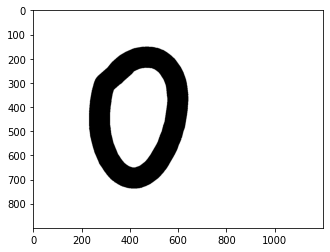

In [ ]:
image = Image.open('../input/trainpart1zip/train/Sample001/img001-001.png')
np_image = np.array(image)
print(np_image.shape)
print(image.mode)
imshow(image)

The image is of dimension 900x1200 with three colour channels. Looking at the images in the directory, I found that all the images are black and white and contain only handwritten digits or alphabets. We can convert them to single grayscale colour channel to reduce computations, improve speed and make the architecture less compled.

## Preprossing the images to convert test and validation input and labels

NOTE: Initially, I tried to build the network on the full image dimension of 900x1200, but that just overloaded the memory with too many parameters.

Since for the later tasks, I have to downsample the images to the size of MNIST i.e. 28x28, I made all other images of this dimension.

Since the images in our dataset are not square, one way to reduce the dimension of images in this set in order to have the same input shape as the MNIST dataset can be to downscale the largest dimension to 28 and then zero-pad the shorter dimension with 0 to make it 28x28.

Also, the 0 values are displayed as black and the higher values as white, which is opposite in our case. Hence, I'll invert time in our dataset ot match to that of MNIST.

So, for our current image of 900x1200, 1200px would be scaled down to 28pxs and 900 would scale down to 900*28/1200 = 21px. Then, I would pad it with 0s in the top and bottom to make it 28x28. I'm padding it with zeros because:
- 0 values don't add any extra information to the image
- The MNIST images have their background values as 0

Instead of padding all the images before training, I would pad them on-the-fly with a Lambda layer in the modes, before passing it to the first convolution layer.

I noticed that after resizing down, the images are still recognizable from each other so, a conv net should be able to recognize them too.


I'll use ImageDataGenerator from Keras to preprocess and split the training images into train and validations sets.

I've normalized all pixel values to be in the range of 0 to 1 for the data to have similar range.

I split the training and validation sets in 80:20 ratio.

In [5]:
train_datagen1 = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=lambda x: 1-x)

I create the generator object which would generate the training and validation sets. It takes the input from the images folder. I'm reducing the size of the images by 20x while taking the input, and changing the colour channel to grayscale.
Each set is of batch size 64. I chose this as it's a good enough batch size for this size of dataset. The class labels are categorical and are one-hot encoded for all of the 62 classes (10 numbers + 26 lowercase alphabets + 26 uppercase alphabets).

Variables that would be used globally. I set max epochs of 400.

In [6]:
BATCH_SIZE = 64
IMAGE_SIZE = (21, 28)
EPOCHS = 400

Using ImageDataGenerator, I convert the images to their one-hot encodings so that the task becomes that of classification, rather than a regression one.

In [7]:
train_generator1 = train_datagen1.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='training',
        seed=42,
        shuffle=True)

Found 1984 images belonging to 62 classes.


In [8]:
validation_generator1 = train_datagen1.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=tf.squeeze(IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='validation',
        seed=42,
        shuffle=True)

Found 496 images belonging to 62 classes.


The ImageDataGenerator class has automatically detected the 62 classes.

Viewing the generated samples

(64, 21, 28, 1) (64, 62)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


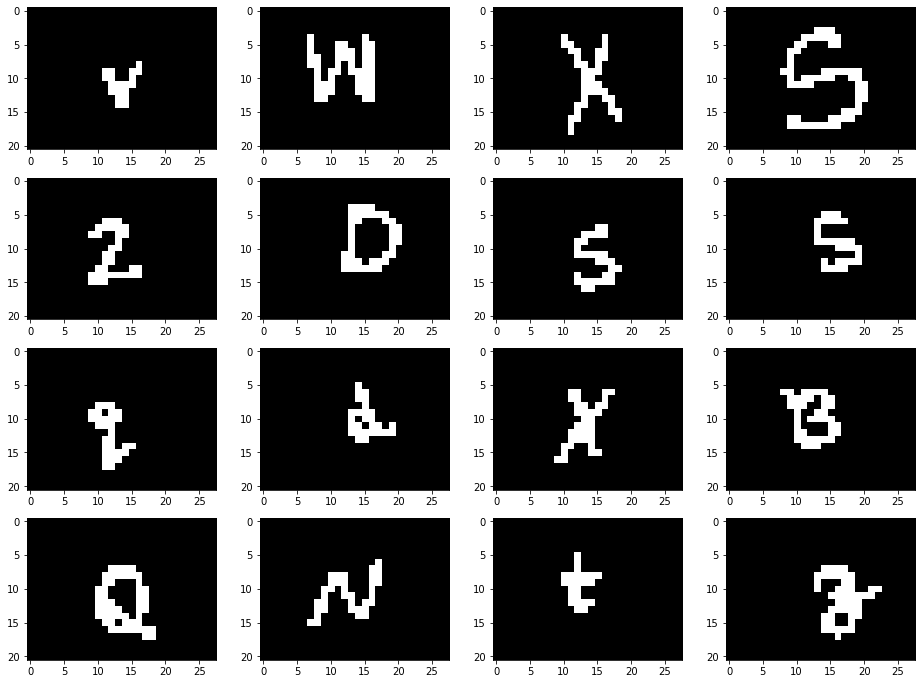

In [ ]:
X_train_batch0, y_train_batch0 = train_generator1.next()
print(X_train_batch0.shape, y_train_batch0.shape)
print(y_train_batch0[0])
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_train_batch0[i]), cmap='gray')
plt.show() 

(64, 21, 28, 1) (64, 62)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


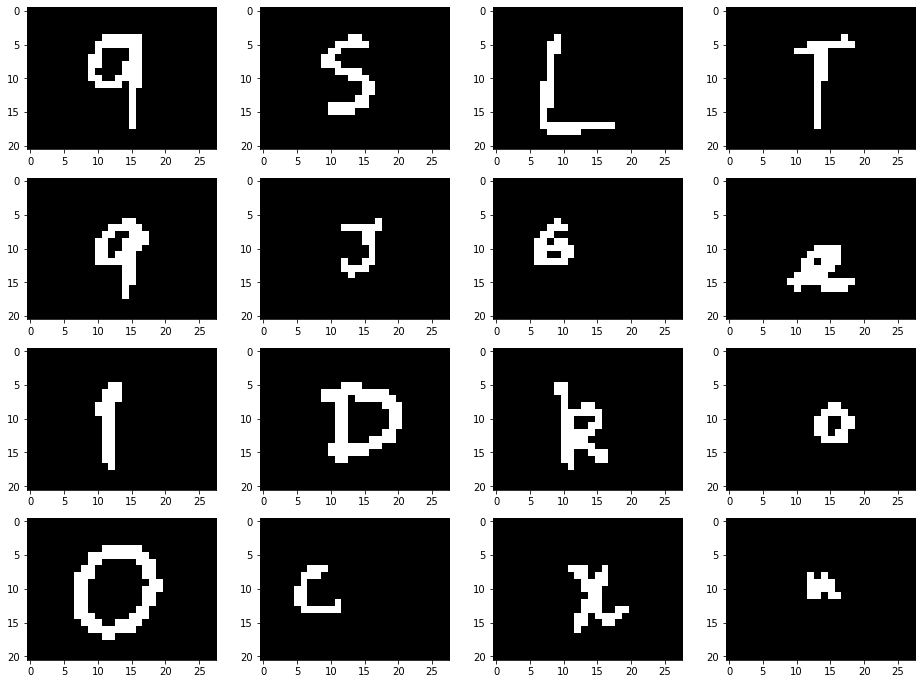

In [ ]:
X_validation_batch0, y_validation_batch0 = validation_generator1.next()
print(X_validation_batch0.shape, y_validation_batch0.shape)
print(y_validation_batch0[0])
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_validation_batch0[i]), cmap='gray')
plt.show() 

## Building the model

I train the model for 400 epochs and use early stopping with a patience level of 20 epochs in order to prevent model from overfitting and save the best weights of the mode.

Using Early Stopping to prevent overfitting, with a patience level of 20 epochs.

In [9]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=20,
    restore_best_weights=True,
    verbose=1)

### Experiment 1: Building the first model inspired from LeNet

I quickly build a first model, which inspired by the original LeNet, with slight modifications, to check how it performs and will then tune the hyperparameter accordingly. I also use dropouts with a probability of 0.4 for each Fully Connected Layer.

In [ ]:
model1 = Sequential()

# Lambda Layer for adding Padding
model1.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE, 1)))

# 1st Convolution Layer
model1.add(Conv2D(6, kernel_size=(5,5), padding='same', activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model1.add(Conv2D(16, kernel_size=(5,5), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model1.add(Flatten())

# 1st Fully Connected Layer
model1.add(Dense(256, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# 2nd Fully Connected Layer
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# Output Layer
model1.add(Dense(62, activation='softmax'))

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)         

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Saving the checkpoint

In [ ]:
checkpoint_filepath1 = 'exp1/checkpoint'
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history1 = model1.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback1, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 39s 1s/step - loss: 5.0043 - accuracy: 0.0213 - val_loss: 4.1208 - val_accuracy: 0.0179
Epoch 2/400
31/31 [==============================] - 36s 1s/step - loss: 4.0452 - accuracy: 0.0806 - val_loss: 4.1611 - val_accuracy: 0.0357
Epoch 3/400
31/31 [==============================] - 36s 1s/step - loss: 3.3932 - accuracy: 0.1817 - val_loss: 4.3968 - val_accuracy: 0.0246
Epoch 4/400
31/31 [==============================] - 36s 1s/step - loss: 3.0605 - accuracy: 0.2270 - val_loss: 4.6091 - val_accuracy: 0.0246
Epoch 5/400
31/31 [==============================] - 36s 1s/step - loss: 2.7359 - accuracy: 0.2881 - val_loss: 4.8350 - val_accuracy: 0.0268
Epoch 6/400
31/31 [==============================] - 36s 1s/step - loss: 2.4506 - accuracy: 0.3656 - val_loss: 4.8434 - val_accuracy: 0.0469
Epoch 7/400
31/31 [==============================] - 36s 1s/step - loss: 2.2959 - accuracy: 0.4072 - val_loss: 4.9224 - val_accuracy: 0.0469
Epoch 8/400
3

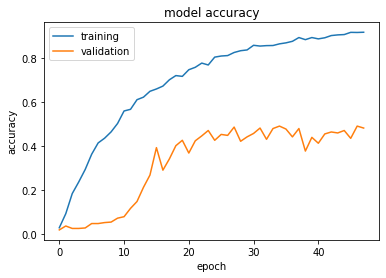

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

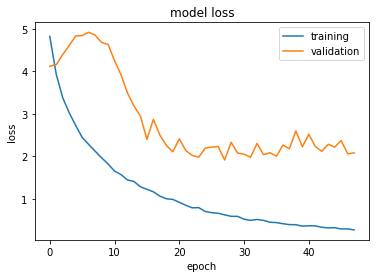

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

The model performs well on the training set but goes not generalizes well on the validation set. The model is overfitting on the training data.

One reason for the overfitting can be that there's not enough training data. For this part of the task, this cannot be improved upon. So, I'll try other ways to reduce overfitting:
- Data Augmentation
- Regularizarion
- Using different activation function
- Changing the model architecture

For regularization, I'm using dropout.

### Experiment 2: Augmenting training data

I augment the data by randomly shearing it by a range of 0.1 and rotating it by a range of 0.5 degrees. 

So, these augmentation methods should help generalize better on unseen images.

#### **Sidenote**: On using other data augmentation techniques

I tried other parameters tool, like horizontal and vertical shifts but, they blurred the images and the training set and they didn't really looked like the validation samples anymore (I also tested them for a small epoch and they were actually giving worse results than the first experiment). I'll show some samples to see why I did not augment much on these images, before going forward with the model building.

##### Unaugmented data

Found 2480 images belonging to 62 classes.


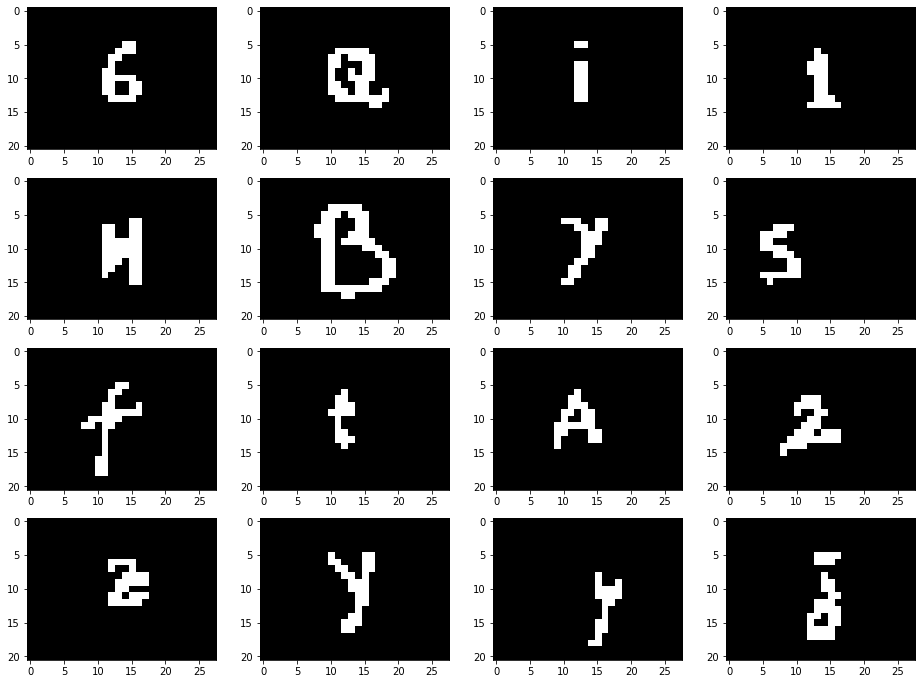

In [ ]:
no_augmentation = ImageDataGenerator(rescale=1./255, preprocessing_function=lambda x: 1-x)

no_augmentation_gen = no_augmentation.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_no_aug, _ = no_augmentation_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_no_aug[i]), cmap='gray')
plt.show() 

##### Checking rotation with max angle of 15

Found 2480 images belonging to 62 classes.


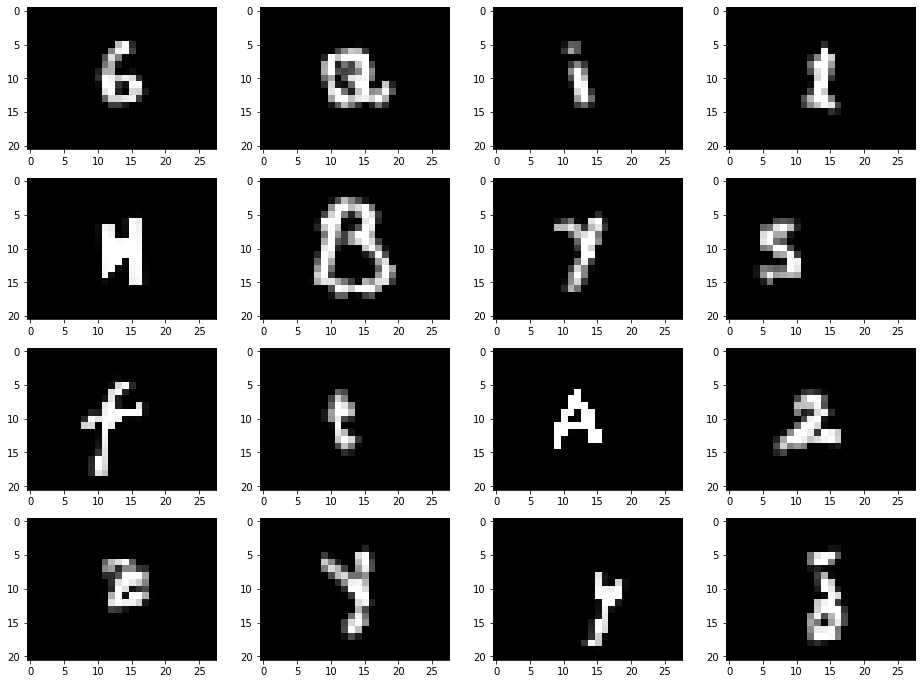

In [ ]:
augmentation_test_rotation = ImageDataGenerator(rescale=1./255, rotation_range=15, preprocessing_function=lambda x: 1-x)

augmentation_test_rotation_gen = augmentation_test_rotation.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_aug_rot, _ = augmentation_test_rotation_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_aug_rot[i]), cmap='gray')
plt.show() 

##### Checking shear with max shear of 0.3

Found 2480 images belonging to 62 classes.


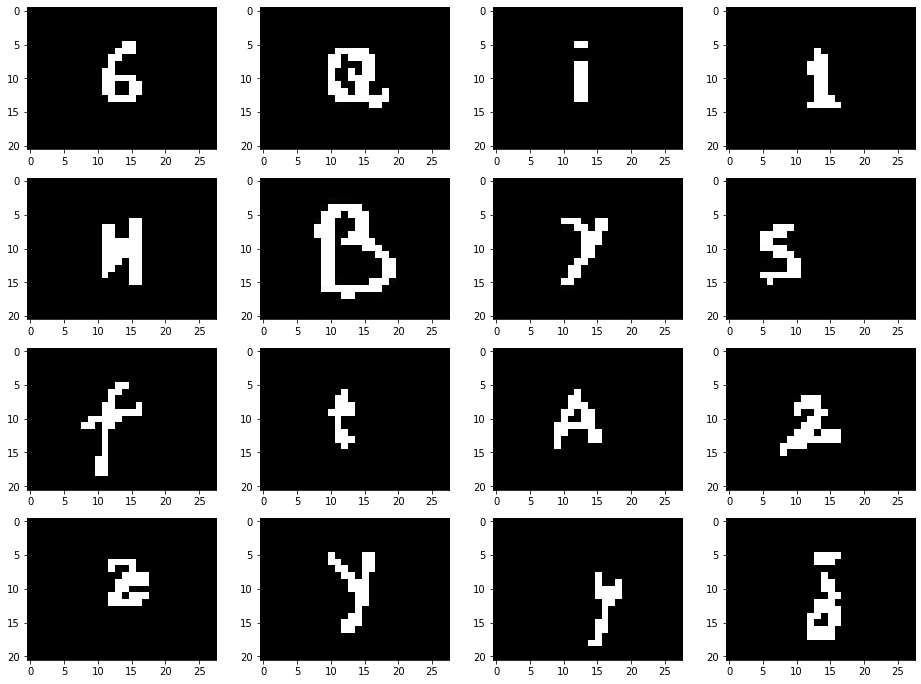

In [ ]:
augmentation_test_shear = ImageDataGenerator(rescale=1./255, shear_range=0.3, preprocessing_function=lambda x: 1-x)

augmentation_test_shear_gen = augmentation_test_shear.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_aug_shear, _ = augmentation_test_shear_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_aug_shear[i]), cmap='gray')
plt.show() 

##### Checking zoom with max zoom of 0.2

Found 2480 images belonging to 62 classes.


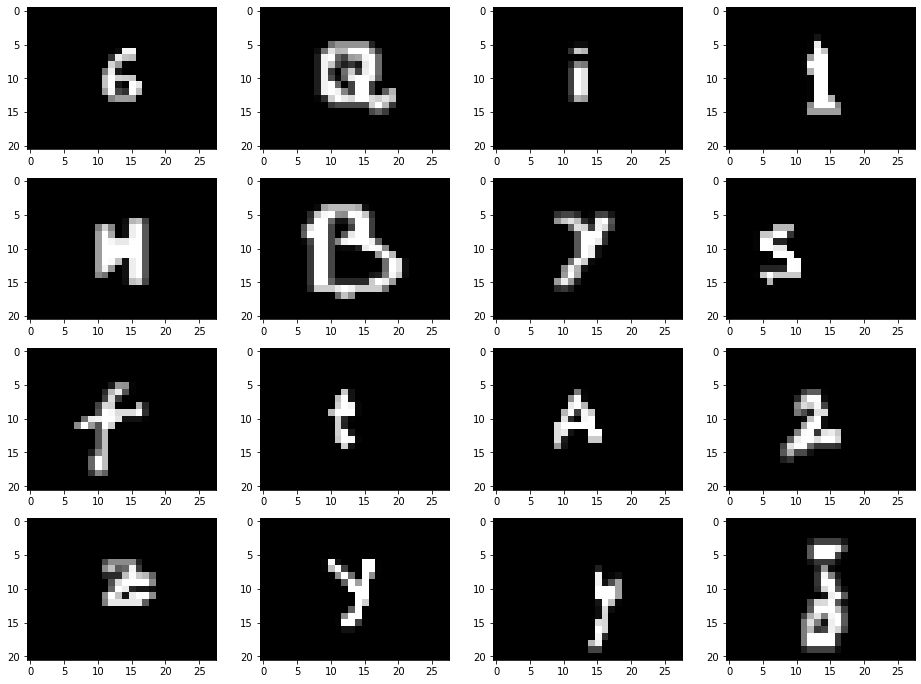

In [ ]:
augmentation_test_zoom = ImageDataGenerator(rescale=1./255, zoom_range=0.2, preprocessing_function=lambda x: 1-x)

augmentation_test_zoom_gen = augmentation_test_zoom.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_aug_zoom, _ = augmentation_test_zoom_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_aug_zoom[i]), cmap='gray')
plt.show() 

##### Checking with horizontal and vertical shift of 0.2

Found 2480 images belonging to 62 classes.


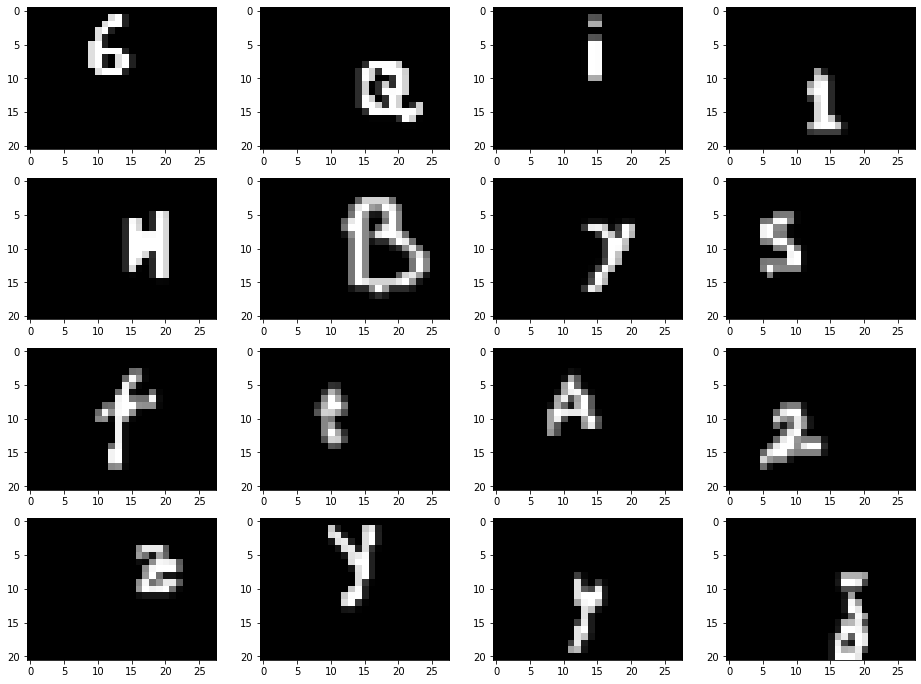

In [ ]:
augmentation_test_shift = ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2, preprocessing_function=lambda x: 1-x)

augmentation_test_shift_gen = augmentation_test_shift.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        seed=42,
        shuffle=True)

X_aug_shift, _ = augmentation_test_shift_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_aug_shift[i]), cmap='gray')
plt.show() 

#### Conclusion: On what augmentation to choose

These augmentations don't turn out very well. They look very different form the training data. I think the closest is the shear, but there's no noticeable effect that I can see from the naked eye. I think I'll still go on with a little of shear and a little of rotation and see how the model performs.

In [ ]:
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.1,
    rotation_range=0.5,
    preprocessing_function=lambda x: 1-x)

validation_datagen2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: 1-x)

In [ ]:
train_generator2 = train_datagen2.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='training',
        seed=42,
        shuffle=True)

Found 1984 images belonging to 62 classes.


In [ ]:
validation_generator2 = validation_datagen2.flow_from_directory(
        '../input/trainpart1zip/train',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='grayscale',
        subset='validation',
        seed=42,
        shuffle=True)

Found 496 images belonging to 62 classes.


Viewing the Generated samples

(64, 21, 28, 1) (64, 62)


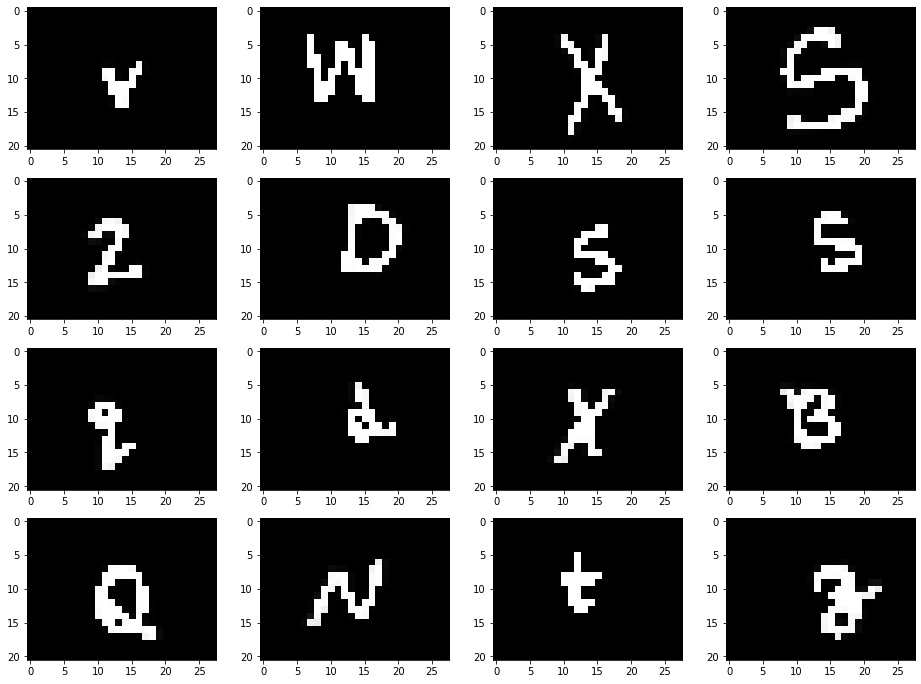

In [ ]:
X_train_batch0, y_train_batch0 = train_generator2.next()
print(X_train_batch0.shape, y_train_batch0.shape)
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_train_batch0[i]), cmap='gray')
plt.show() 

(64, 21, 28, 1) (64, 62)


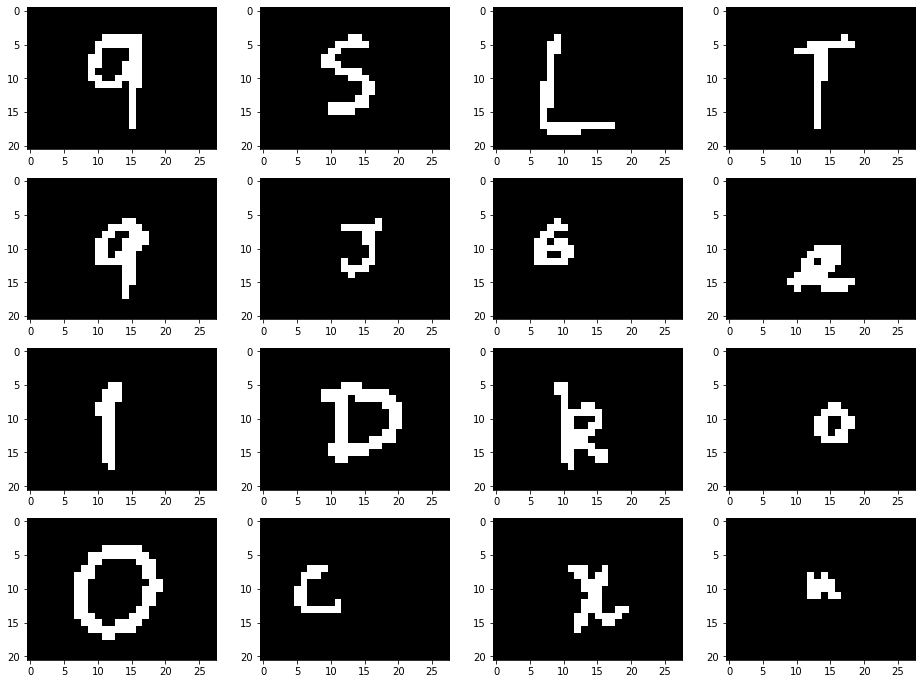

In [ ]:
X_validation_batch0, y_validation_batch0 = validation_generator2.next()
print(X_validation_batch0.shape, y_validation_batch0.shape)
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_validation_batch0[i]), cmap='gray')
plt.show() 

Using the same architecture as before

In [ ]:
model2 = Sequential()

# Lambda Layer for adding Padding
model2.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE, 1)))

# 1st Convolution Layer
model2.add(Conv2D(6, kernel_size=(5,5), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model2.add(Conv2D(16, kernel_size=(5,5), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model2.add(Flatten())

# 1st Fully Connected Layer
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# 2nd Fully Connected Layer
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# Output Layer
model2.add(Dense(62, activation='softmax'))

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 16)         

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Saving the checkpoint

In [ ]:
checkpoint_filepath2 = 'exp2/checkpoint'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history2 = model2.fit(
    train_generator2,
    epochs=EPOCHS,
    validation_data=validation_generator2,
    steps_per_epoch = train_generator2.samples // BATCH_SIZE,
    validation_steps = validation_generator2.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback2, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 39s 1s/step - loss: 4.9179 - accuracy: 0.0292 - val_loss: 4.1171 - val_accuracy: 0.0134
Epoch 2/400
31/31 [==============================] - 37s 1s/step - loss: 3.9544 - accuracy: 0.0845 - val_loss: 4.2481 - val_accuracy: 0.0223
Epoch 3/400
31/31 [==============================] - 37s 1s/step - loss: 3.3298 - accuracy: 0.1834 - val_loss: 4.4117 - val_accuracy: 0.0179
Epoch 4/400
31/31 [==============================] - 37s 1s/step - loss: 2.9691 - accuracy: 0.2378 - val_loss: 4.4836 - val_accuracy: 0.0223
Epoch 5/400
31/31 [==============================] - 37s 1s/step - loss: 2.7160 - accuracy: 0.3004 - val_loss: 4.7244 - val_accuracy: 0.0246
Epoch 6/400
31/31 [==============================] - 37s 1s/step - loss: 2.4925 - accuracy: 0.3474 - val_loss: 4.7267 - val_accuracy: 0.0290
Epoch 7/400
31/31 [==============================] - 38s 1s/step - loss: 2.2964 - accuracy: 0.3897 - val_loss: 4.6166 - val_accuracy: 0.0402
Epoch 8/400
3

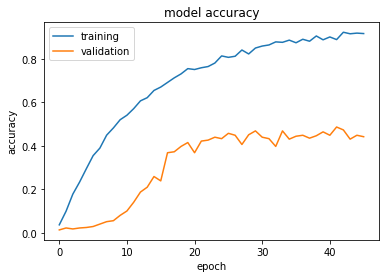

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

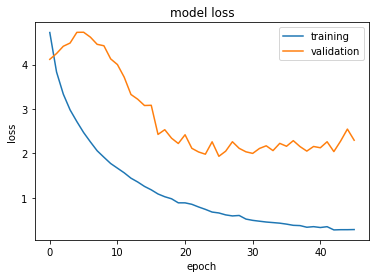

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

There's no visible improvements, than the first experiment. I think this is so becuase in this case, even slightly augmenting data leads to larger variations and since we don't have a lot of training samples, it still overfits to this data and does not generalize well on the validation set. So, I'll not use regularization in further experiments.

### Experiment 3: Using different activation function: Mish

From refs. [4] and [5], I will use the new Mish activation over ReLU. I'll use the training samples from first experiment as they gave better results than the second experiment and will use the same activation.

In [10]:
# Mish Activation Function
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.math.log(1+tf.exp(x))))(x)

In [ ]:
model3 = Sequential()

# Lambda Layer for adding Padding
model3.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE, 1)))

# 1st Convolution Layer
model3.add(Conv2D(6, kernel_size=(5,5), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model3.add(Conv2D(16, kernel_size=(5,5), activation=mish))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model3.add(Flatten())

# 1st Fully Connected Layer
model3.add(Dense(256, activation=mish))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

# 2nd Fully Connected Layer
model3.add(Dense(128, activation=mish))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

# Output Layer
model3.add(Dense(62, activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_17 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)         

In [ ]:
model3.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Saving the checkpoint

In [ ]:
checkpoint_filepath3 = 'exp3/checkpoint'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history3 = model3.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback3, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 40s 1s/step - loss: 4.9238 - accuracy: 0.0266 - val_loss: 4.1515 - val_accuracy: 0.0134
Epoch 2/400
31/31 [==============================] - 37s 1s/step - loss: 3.8077 - accuracy: 0.0993 - val_loss: 4.2567 - val_accuracy: 0.0156
Epoch 3/400
31/31 [==============================] - 37s 1s/step - loss: 3.2195 - accuracy: 0.1945 - val_loss: 4.3816 - val_accuracy: 0.0179
Epoch 4/400
31/31 [==============================] - 37s 1s/step - loss: 2.8448 - accuracy: 0.2681 - val_loss: 4.4611 - val_accuracy: 0.0134
Epoch 5/400
31/31 [==============================] - 37s 1s/step - loss: 2.5315 - accuracy: 0.3386 - val_loss: 4.4283 - val_accuracy: 0.0179
Epoch 6/400
31/31 [==============================] - 37s 1s/step - loss: 2.2639 - accuracy: 0.4173 - val_loss: 4.4882 - val_accuracy: 0.0179
Epoch 7/400
31/31 [==============================] - 37s 1s/step - loss: 2.1102 - accuracy: 0.4271 - val_loss: 4.4642 - val_accuracy: 0.0246
Epoch 8/400
3

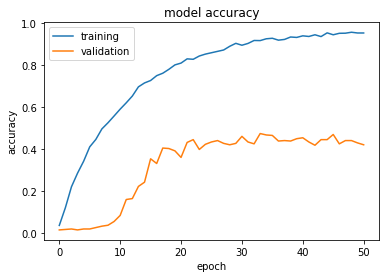

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

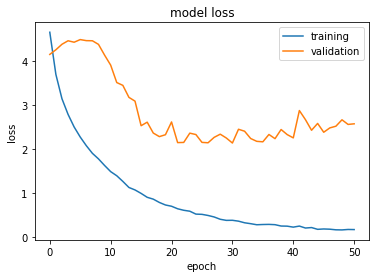

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This model performs "slightly" better than our model from Experiment 1 and also does so in less epochs. However, there is some variance as the model overfits. We used early stopping with patience level 20, so our model gives best results at around epoch 31.

### Experiment 4: Using higher temperature in Softmax

Higher temperature in softmax helps get 'softer' weights. This can help improve accuracy further as the 'probability' is nor more evenly distributed across the classes.

In [ ]:
model4 = Sequential()

# Lambda Layer for adding Padding
model4.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE, 1)))

# 1st Convolution Layer
model4.add(Conv2D(6, kernel_size=(5,5), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model4.add(Conv2D(16, kernel_size=(5,5), activation=mish))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model4.add(Flatten())

# 1st Fully Connected Layer
model4.add(Dense(256, activation=mish))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

# 2nd Fully Connected Layer
model4.add(Dense(128, activation=mish))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

# Output Layer
# Increasing the softmax temperature
temp = 5
model4.add(Lambda(lambda x: x / temp))
model4.add(Dense(62, activation='softmax'))

In [ ]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)         

In [ ]:
model4.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
checkpoint_filepath4 = 'exp4/checkpoint'
model_checkpoint_callback4 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath4,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history4 = model4.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback4, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 63s 991ms/step - loss: 4.1323 - accuracy: 0.0277 - val_loss: 4.1238 - val_accuracy: 0.0134
Epoch 2/400
31/31 [==============================] - 30s 980ms/step - loss: 3.8507 - accuracy: 0.1154 - val_loss: 4.1265 - val_accuracy: 0.0179
Epoch 3/400
31/31 [==============================] - 30s 974ms/step - loss: 3.6529 - accuracy: 0.2144 - val_loss: 4.1399 - val_accuracy: 0.0179
Epoch 4/400
31/31 [==============================] - 30s 977ms/step - loss: 3.4515 - accuracy: 0.2855 - val_loss: 4.1655 - val_accuracy: 0.0179
Epoch 5/400
31/31 [==============================] - 30s 973ms/step - loss: 3.2286 - accuracy: 0.3662 - val_loss: 4.1651 - val_accuracy: 0.0179
Epoch 6/400
31/31 [==============================] - 30s 973ms/step - loss: 3.0389 - accuracy: 0.4318 - val_loss: 4.1768 - val_accuracy: 0.0156
Epoch 7/400
31/31 [==============================] - 30s 976ms/step - loss: 2.8271 - accuracy: 0.4688 - val_loss: 4.1357 - val_accuracy:

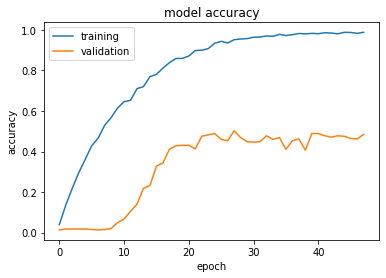

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

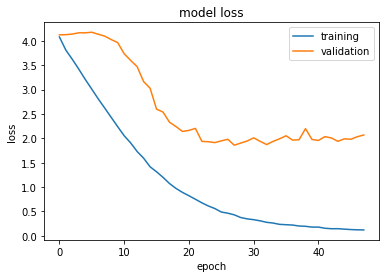

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This is a slight improvement over the last experiment. This can be due to the case that the 'probabilities' are now more spread out.

### Experiment 5: Changing the Model Architecture

From ref. [1] and [2], I modify the architecture to see if it gives better results. This model is actually shown to give some very good results on the MNIST competition in Kaggle.

In [12]:
model5 = Sequential()

# Lambda Layer for adding Padding
model5.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE, 1)))

# 1st Convolution Layer
model5.add(Conv2D(32, kernel_size=3, activation=mish))
model5.add(BatchNormalization())
model5.add(Conv2D(32, kernel_size=3, activation=mish))
model5.add(BatchNormalization())
model5.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation=mish))
model5.add(BatchNormalization())
model5.add(Dropout(0.4))

# 2nd Convolution Layer
model5.add(Conv2D(64, kernel_size=3, activation=mish))
model5.add(BatchNormalization())
model5.add(Conv2D(64, kernel_size=3, activation=mish))
model5.add(BatchNormalization())
model5.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=mish))
model5.add(BatchNormalization())
model5.add(Dropout(0.4))

# 3rd Convolution Layer
model5.add(Conv2D(128, kernel_size = 4, activation=mish))
model5.add(BatchNormalization())

# Passing to a Fully Connected Layer
model5.add(Flatten())
model5.add(Dropout(0.4))

# Output Layer
# Increasing the softmax temperature
temp = 5
model5.add(Lambda(lambda x: x / temp))

model5.add(Dense(62, activation='softmax'))

In [13]:
model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 12, 32)       

In [18]:
model5.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Saving the Checkpoint

In [19]:
checkpoint_filepath5 = 'exp5/checkpoint'
model_checkpoint_callback5 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath5,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [20]:
history5 = model5.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback5, early_stopping_callback]
)

Epoch 1/400
31/31 [==============================] - 33s 1s/step - loss: 3.1841 - accuracy: 0.3234 - val_loss: 4.0727 - val_accuracy: 0.0246
Epoch 2/400
31/31 [==============================] - 31s 1s/step - loss: 2.9242 - accuracy: 0.4321 - val_loss: 4.1239 - val_accuracy: 0.0290
Epoch 3/400
31/31 [==============================] - 31s 1000ms/step - loss: 2.6343 - accuracy: 0.5060 - val_loss: 4.0812 - val_accuracy: 0.0446
Epoch 4/400
31/31 [==============================] - 31s 1s/step - loss: 2.4394 - accuracy: 0.5597 - val_loss: 4.0960 - val_accuracy: 0.0424
Epoch 5/400
31/31 [==============================] - 31s 1s/step - loss: 2.1861 - accuracy: 0.6308 - val_loss: 4.0556 - val_accuracy: 0.0536
Epoch 6/400
31/31 [==============================] - 31s 1s/step - loss: 1.9959 - accuracy: 0.6641 - val_loss: 3.9447 - val_accuracy: 0.0915
Epoch 7/400
31/31 [==============================] - 31s 1s/step - loss: 1.7984 - accuracy: 0.6955 - val_loss: 3.7015 - val_accuracy: 0.1161
Epoch 8/4

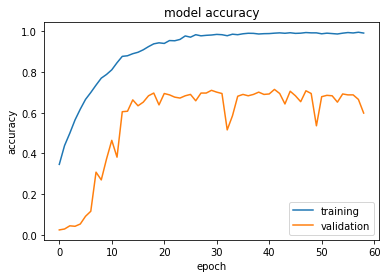

In [21]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

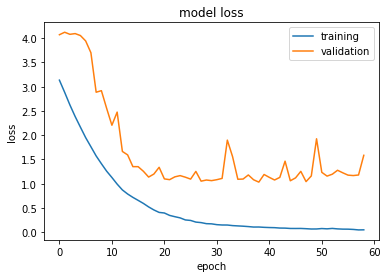

In [22]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This gives the best accuracy among all of the previous examples. Works great!

### Experiment 6: Changing the Model Architecture even further: Using Efficientnet

Effecient Net is being used a lot nowdays so, I'll see how this architecture works for this dataset. I don't have very high hopes for this because:
1. We are not using pre-trained weights
2. We don't have a large trainign data

But I'll still give it a try to see how it does.

For this EfficientNet Model, I would use Early Stopping with larger patience value. This is so because the Keras Website says

> "Note: the accuracy will increase very slowly and may overfit."

on Training a model with EfficientNet from scratch.


Saving the Checkpoint

In [ ]:
checkpoint_filepath6 = 'exp6/checkpoint'
model_checkpoint_callback6 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath6,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

Early Stopping Callback

In [ ]:
early_stopping_callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100,
    restore_best_weights=True,
    verbose=1)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Initializer taken from the source code
DENSE_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 1. / 3.,
        'mode': 'fan_out',
        'distribution': 'uniform'
    }
}

# Input Layer
inputs = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 1))

# Lambda Layer for adding Padding
x = tf.keras.layers.Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE, 1))(inputs)

# Efficient layer except the top layer
x = EfficientNetB0(include_top=False, weights=None,
    input_shape=(48, 48, 1))(x)

# Top

# Global Average Pooling Layer
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = tf.keras.layers.Dropout(0.4, name='top_dropout')(x)

# Output Layer
outputs = tf.keras.layers.Dense(62,
    activation='softmax',
    kernel_initializer=DENSE_KERNEL_INITIALIZER,
    name='predictions')(x)

model6 = tf.keras.Model(inputs, outputs)

model6.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

model6.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 45, 60, 1)]       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4048991   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
predictions (Dense)          (None, 62)                79422     
Total params: 4,128,413
Trainable params: 4,086,394
Non-trainable params: 42,019
_________________________________________________________________


In [ ]:
history6 = model6.fit(
    train_generator1,
    epochs=EPOCHS,
    validation_data=validation_generator1,
    steps_per_epoch = train_generator1.samples // BATCH_SIZE,
    validation_steps = validation_generator1.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback6, early_stopping_callback2]
)

Epoch 1/400
31/31 [==============================] - 42s 1s/step - loss: 4.9151 - accuracy: 0.0201 - val_loss: 4.1315 - val_accuracy: 0.0179
Epoch 2/400
31/31 [==============================] - 32s 1s/step - loss: 4.4224 - accuracy: 0.0468 - val_loss: 4.1495 - val_accuracy: 0.0156
Epoch 3/400
31/31 [==============================] - 32s 1s/step - loss: 4.2469 - accuracy: 0.0709 - val_loss: 4.1952 - val_accuracy: 0.0179
Epoch 4/400
31/31 [==============================] - 32s 1s/step - loss: 3.8510 - accuracy: 0.1198 - val_loss: 4.2058 - val_accuracy: 0.0134
Epoch 5/400
31/31 [==============================] - 32s 1s/step - loss: 3.4325 - accuracy: 0.2088 - val_loss: 4.2741 - val_accuracy: 0.0156
Epoch 6/400
31/31 [==============================] - 32s 1s/step - loss: 2.8368 - accuracy: 0.3269 - val_loss: 4.3717 - val_accuracy: 0.0179
Epoch 7/400
31/31 [==============================] - 32s 1s/step - loss: 2.2589 - accuracy: 0.4527 - val_loss: 4.7584 - val_accuracy: 0.0156
Epoch 8/400
3

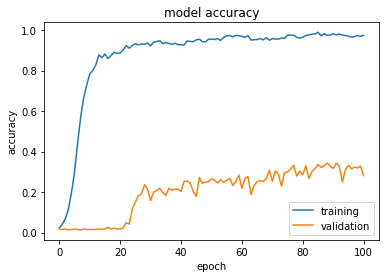

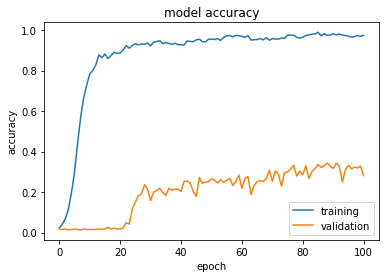

In [ ]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

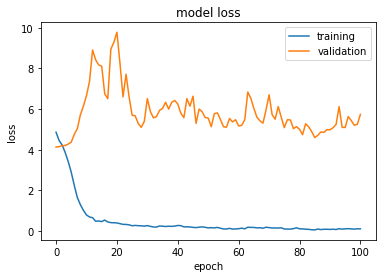

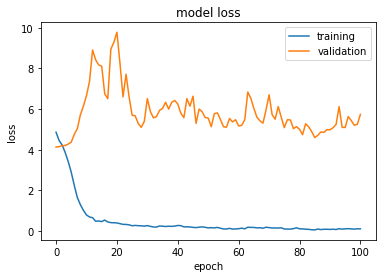

In [ ]:
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

As expected, this does not converge. Infact, it's only half as good. This accuracy result is similar to the one shown in ref. [6] [here](https://keras.io/img/examples/vision/image_classification_efficientnet_fine_tuning/image_classification_efficientnet_fine_tuning_20_0.png).

## Observations form these experiments

- I downscaled the images to the dimensions of that of the MNIST Images while making sure that the images are still recognizable from each other. This would reduce the number of parameters in our network. I also padded the images with 0 to maintain the aspect ratio and inverted the images so that the background now has 0 as the pixel value.
- I started with a modified version of the original LeNet, which was used to classify on the MNIST dataset, as our current dataset closely resembles it, I got an accuracy of around 50%.
- Data Augmentation did not help for this dataset as the augmented data was very different from the original data and it actually performed worse. I did not use Data augmentation for later experiments.
- I tried the Mish Activation function instead of ReLU and it reached the the same accuracy in lesser epochs, however it had some variance issues for the training accuracy in the later epochs.
- Using Softmax with greater temperature, which spreads the probabilities and it actually gave similar results in lesser epochs.
- I tried different architectures: One which is known to give pretty good accuracy on the MNIST dataset in Kaggle Competitions and one Modified EfficientNet Architecture.
    - The first of them gave very good results compared to the original LeNet and in lesser epoch. **It achieved an accuracy of 71.43%**! An improvement of more than 20% on the original experiment.
    - The EfficientNet architecture actually gave the worst results in all of the experiments, but I think this was due to the scarcity of training data and not using a pretrained model.


## Conclusions and Future Improvements

- Overall, I think the Experiment 5 gave very good result, with around 71.43% accuracy, followed by LeNet with Mish and higher temperature Softmax. Clearly, the models were overfitting the data and I think that if trained with more data, they would perform better. For the future parts of this task, I would be using these two architectures.
- EfficientNet can give better results than from Experiment 6 but again, it neeeds more data and some pre-trainined weights. EfficientNetV2, released recently can also be a good model, but I can't find an Open Source Implementation of it and it's a little complex to build it in this duration, so I didn not try it, but I'm sure that it would give better results than what I got from EfficientNet here.
- I have tuned the hyperparameters from what I could read online. However, I think using [Weights & Biases Sweeps](https://docs.wandb.com/sweeps/overview) would give better insights. I got to know about this relatively late and there was not much time left to set it up. But it would be sweet in the future to improve the model using this.

# References

- [1] [EMNIST handwritten character recognition with Deep Learning](https://medium.com/@mrkardostamas/emnist-handwritten-character-recognition-with-deep-learning-b5d61ac1aab7)
- [2] [How to choose CNN Architecture MNIST](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist)
- [3] [Swish Vs Mish: Latest Activation Functions](https://krutikabapat.github.io/Swish-Vs-Mish-Latest-Activation-Functions/)
- [4] [Mish Class Definition in Keras](https://gist.github.com/digantamisra98/35ca0ec94ebefb99af6f444922fa52cd)
- [5] [Mnist_EfficientNet Kaggle Notebook](https://www.kaggle.com/ateplyuk/mnist-efficientnet)
- [6] [Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#training-a-model-from-scratch)
- [7] [Keras EfficientNet Implementation Source Code](https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/applications/efficientnet.py#L517-L540)
- [8] [Keras ModelCheckpoint Documentaion](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)
- [9] [Keras EarlyStopping Documentaion](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- [10] [Keras ImageDataGenerator Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- [11] [Keras EfficientNetB0 Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0)
- [12] [Effect of Batch Size on Neural Net Training](https://medium.com/deep-learning-experiments/effect-of-batch-size-on-neural-net-training-c5ae8516e57)
- [13] [How does temperature affect softmax in machine learning?](http://www.kasimte.com/2020/02/14/how-does-temperature-affect-softmax-in-machine-learning.html)
- [14] [Temperatured softmax · Issue #3092 · keras-team/keras](https://github.com/keras-team/keras/issues/3092)
- [15] [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298.pdf)
- [16] [Notes from Deeplearning.ai's Deep Learning Speciaization](https://www.coursera.org/specializations/deep-learning)